# Train CNN with MFCCs


Inspired by https://medium.com/@diego-rios/speech-emotion-recognition-with-convolutional-neural-network-ae5406a1c0f7

Trained with an updated model architecture, CNNMFCCs2


Import the necessary libraries


In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchview import draw_graph
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import os
import sys
import numpy as np
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.1+cu118
True


Set the seed for reproducibility


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
MODEL = 'cnn_mfccs'

train_csv = '../../../data/mfcc_train_dataset.csv'
test_csv = '../../../data/mfcc_test_dataset.csv'
val_csv = '../../../data/mfcc_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mfcc tensors


In [6]:
from datasets.MfccDataset import MFCCDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Import the model


In [ ]:
from CNNMFCCs2 import CNNMFCCs2

model = CNNMFCCs2()

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNMFCCs(
  (conv1): Conv1d(40, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

Visualize the model


In [13]:
summary(model, (40, 172))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 172]           3,872
       BatchNorm1d-2              [-1, 32, 172]              64
            Conv1d-3               [-1, 64, 86]           6,208
       BatchNorm1d-4               [-1, 64, 86]             128
            Conv1d-5              [-1, 128, 43]          24,704
       BatchNorm1d-6              [-1, 128, 43]             256
            Conv1d-7              [-1, 256, 21]          98,560
       BatchNorm1d-8              [-1, 256, 21]             512
 AdaptiveAvgPool1d-9               [-1, 256, 1]               0
          Dropout-10                  [-1, 256]               0
           Linear-11                  [-1, 128]          32,896
          Dropout-12                  [-1, 128]               0
           Linear-13                    [-1, 9]           1,161
Total params: 168,361
Trainable params:

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [14]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adamax(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([])

epochs = 100

Execute the training


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 46.03it/s, Loss=1.118652105331421, Elapsed=1.9783s, ETA=0.0000s] 

Epoch 1 completed in 8.6886s
Train Loss: 1.4361677707275213 - Train Accuracy: 38.39804617715565
Validation Loss: 1.1838692450523376 - Validation Accuracy: 47.3723089911355

Epoch 2/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.29it/s, Loss=1.0861860513687134, Elapsed=1.5353s, ETA=0.0000s]


Epoch 2 completed in 7.3141s
Train Loss: 1.132271592327625 - Train Accuracy: 49.6370502702336
Validation Loss: 1.0269564302762348 - Validation Accuracy: 54.72773322076826

Epoch 3/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 62.60it/s, Loss=0.7659549713134766, Elapsed=1.5451s, ETA=0.0000s]


Epoch 3 completed in 7.0882s
Train Loss: 1.0155209111685009 - Train Accuracy: 54.76809660568508
Validation Loss: 0.9327981146176656 - Validation Accuracy: 57.50316589278176

Epoch 4/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 64.45it/s, Loss=0.7097488045692444, Elapsed=1.6191s, ETA=0.0000s]

Epoch 4 completed in 6.9650s
Train Loss: 0.9487046490859434 - Train Accuracy: 57.94305872775378
Validation Loss: 0.8872526621818543 - Validation Accuracy: 61.449978894048115

Epoch 5/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 59.97it/s, Loss=0.8098166584968567, Elapsed=1.5700s, ETA=0.0000s]

Epoch 5 completed in 6.8628s
Train Loss: 0.9007298880918867 - Train Accuracy: 60.21573460573031
Validation Loss: 0.8700976626078287 - Validation Accuracy: 62.473617560151965

Epoch 6/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.08it/s, Loss=0.8190576434135437, Elapsed=1.5508s, ETA=0.0000s]

Epoch 6 completed in 6.7005s
Train Loss: 0.8652451432853765 - Train Accuracy: 61.48888537120373
Validation Loss: 0.869025293191274 - Validation Accuracy: 62.05149852258337

Epoch 7/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.14it/s, Loss=0.6176923513412476, Elapsed=1.5140s, ETA=0.0000s]

Epoch 7 completed in 6.7844s
Train Loss: 0.8261908496046342 - Train Accuracy: 63.435924108455254
Validation Loss: 0.8274706061681112 - Validation Accuracy: 64.03545799915577

Epoch 8/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.06it/s, Loss=0.7475579977035522, Elapsed=1.5433s, ETA=0.0000s]

Epoch 8 completed in 6.9810s
Train Loss: 0.801807824759125 - Train Accuracy: 64.46936975645056
Validation Loss: 0.8546743273735047 - Validation Accuracy: 63.644997889404806

Epoch 9/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.57it/s, Loss=0.4054429233074188, Elapsed=1.5361s, ETA=0.0000s]

Epoch 9 completed in 6.8977s
Train Loss: 0.7761909636975712 - Train Accuracy: 65.59779290382397
Validation Loss: 0.8246394511063894 - Validation Accuracy: 64.3520472773322

Epoch 10/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 56.70it/s, Loss=0.4882061779499054, Elapsed=1.7671s, ETA=0.0000s]

Epoch 10 completed in 7.5082s
Train Loss: 0.7596364843018483 - Train Accuracy: 66.35309016078334
Validation Loss: 0.7966560296217601 - Validation Accuracy: 63.57112705783031

Epoch 11/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.59it/s, Loss=0.49959781765937805, Elapsed=1.4491s, ETA=0.0000s]

Epoch 11 completed in 6.7943s
Train Loss: 0.7386715904825685 - Train Accuracy: 67.06089866805364
Validation Loss: 0.7924058902263641 - Validation Accuracy: 66.48374841705362

Epoch 12/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.55it/s, Loss=0.27743467688560486, Elapsed=1.6002s, ETA=0.0000s]

Epoch 12 completed in 7.0836s
Train Loss: 0.7238498767676381 - Train Accuracy: 67.76870717532394
Validation Loss: 0.7350156644980113 - Validation Accuracy: 66.87420852680455

Epoch 13/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.84it/s, Loss=0.32388755679130554, Elapsed=1.6055s, ETA=0.0000s]

Epoch 13 completed in 6.8795s
Train Loss: 0.7080732762296765 - Train Accuracy: 68.59636824133331
Validation Loss: 0.7625601351261139 - Validation Accuracy: 65.44955677501055

Epoch 14/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.00it/s, Loss=0.4856623411178589, Elapsed=1.6087s, ETA=0.0000s]

Epoch 14 completed in 6.9455s
Train Loss: 0.6961974050268273 - Train Accuracy: 68.90843716786142
Validation Loss: 0.7255874911944071 - Validation Accuracy: 69.744617982271

Epoch 15/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.75it/s, Loss=0.559032678604126, Elapsed=1.5277s, ETA=0.0000s] 

Epoch 15 completed in 7.0211s
Train Loss: 0.6755271645295138 - Train Accuracy: 69.6999163293458
Validation Loss: 0.729631374279658 - Validation Accuracy: 68.8159560996201

Epoch 16/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.27it/s, Loss=0.19474658370018005, Elapsed=1.5620s, ETA=0.0000s]

Epoch 16 completed in 7.0519s
Train Loss: 0.6647035003225238 - Train Accuracy: 70.1386219217114
Validation Loss: 0.7423169147968293 - Validation Accuracy: 67.4018573237653

Epoch 17/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.24it/s, Loss=0.42753082513809204, Elapsed=1.5858s, ETA=0.0000s]

Epoch 17 completed in 7.0919s
Train Loss: 0.6501660707885819 - Train Accuracy: 70.85999864317859
Validation Loss: 0.7316933536529541 - Validation Accuracy: 69.31194596876318

Epoch 18/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.20it/s, Loss=0.3035135865211487, Elapsed=1.6465s, ETA=0.0000s] 

Epoch 18 completed in 7.4911s
Train Loss: 0.6413859669872791 - Train Accuracy: 71.03186268967234
Validation Loss: 0.7096380297342936 - Validation Accuracy: 72.02406078514142

Epoch 19/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 58.91it/s, Loss=0.2971343398094177, Elapsed=1.6127s, ETA=0.0000s]

Epoch 19 completed in 7.1371s
Train Loss: 0.6277654381156657 - Train Accuracy: 71.93867167183012
Validation Loss: 0.7063095601399739 - Validation Accuracy: 71.05318699873364

Epoch 20/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.49it/s, Loss=0.37426334619522095, Elapsed=1.4785s, ETA=0.0000s]

Epoch 20 completed in 7.2135s
Train Loss: 0.6173646190779747 - Train Accuracy: 72.16028583704575
Validation Loss: 0.7093645095825195 - Validation Accuracy: 70.9476572393415

Epoch 21/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.94it/s, Loss=0.2472575306892395, Elapsed=1.5363s, ETA=0.0000s] 

Epoch 21 completed in 6.9449s
Train Loss: 0.6090261478816843 - Train Accuracy: 72.39094547839262
Validation Loss: 0.6922008383274079 - Validation Accuracy: 71.07429295061208

Epoch 22/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.97it/s, Loss=0.5444101691246033, Elapsed=1.5774s, ETA=0.0000s] 


Epoch 22 completed in 7.3131s
Train Loss: 0.5985780401381454 - Train Accuracy: 72.80929874946293
Validation Loss: 0.7226623594760895 - Validation Accuracy: 72.81553398058253

Epoch 23/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 66.45it/s, Loss=0.2531930208206177, Elapsed=1.4693s, ETA=0.0000s]

Epoch 23 completed in 6.8844s
Train Loss: 0.5895160288479976 - Train Accuracy: 73.19147011600823
Validation Loss: 0.7158792169888815 - Validation Accuracy: 68.46770789362601

Epoch 24/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.59it/s, Loss=0.5133901238441467, Elapsed=1.5238s, ETA=0.0000s] 

Epoch 24 completed in 6.9390s
Train Loss: 0.5807726204050758 - Train Accuracy: 73.44926618574885
Validation Loss: 0.6979379721482595 - Validation Accuracy: 72.5833685099198

Epoch 25/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 59.88it/s, Loss=0.3001513183116913, Elapsed=1.6966s, ETA=0.0000s] 

Epoch 25 completed in 7.0602s
Train Loss: 0.5692597947196464 - Train Accuracy: 73.94902874200041
Validation Loss: 0.7215719886620839 - Validation Accuracy: 72.12959054453356

Epoch 26/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.28it/s, Loss=0.26431548595428467, Elapsed=1.5982s, ETA=0.0000s]


Epoch 26 completed in 7.1113s
Train Loss: 0.5537058720526667 - Train Accuracy: 74.50306415503945
Validation Loss: 0.7171436087290446 - Validation Accuracy: 70.9476572393415

Epoch 27/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 66.23it/s, Loss=0.1433883160352707, Elapsed=1.4745s, ETA=0.0000s] 

Epoch 27 completed in 6.7872s
Train Loss: 0.5508284080407523 - Train Accuracy: 74.38547296533321
Validation Loss: 0.7191860924164454 - Validation Accuracy: 71.50696496411987

Epoch 28/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.05it/s, Loss=0.20116853713989258, Elapsed=1.6070s, ETA=0.0000s]

Epoch 28 completed in 7.0393s
Train Loss: 0.5415605621014027 - Train Accuracy: 75.03222450871758
Validation Loss: 0.7142072888215383 - Validation Accuracy: 72.97382861967074

Epoch 29/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.82it/s, Loss=0.4943014681339264, Elapsed=1.5332s, ETA=0.0000s] 


Epoch 29 completed in 7.1007s
Train Loss: 0.5354033607795748 - Train Accuracy: 75.2334863526379
Validation Loss: 0.7674243565400442 - Validation Accuracy: 70.72604474461798

Epoch 30/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 58.24it/s, Loss=0.24050508439540863, Elapsed=1.7189s, ETA=0.0000s]

Epoch 30 completed in 7.3388s
Train Loss: 0.5284222742553392 - Train Accuracy: 75.73777164695507
Validation Loss: 0.7192647049824397 - Validation Accuracy: 71.32756437315322

Epoch 31/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 58.23it/s, Loss=0.29142260551452637, Elapsed=1.6161s, ETA=0.0000s]

Epoch 31 completed in 7.1968s
Train Loss: 0.5127996922917448 - Train Accuracy: 75.98199950249881
Validation Loss: 0.7471984505653382 - Validation Accuracy: 71.89742507387083

Epoch 32/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.21it/s, Loss=0.2077205777168274, Elapsed=1.4588s, ETA=0.0000s]

Epoch 32 completed in 6.9090s
Train Loss: 0.5097595920969296 - Train Accuracy: 76.00461319282694
Validation Loss: 0.7479026595751445 - Validation Accuracy: 71.31701139721402

Epoch 33/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 58.15it/s, Loss=0.3446475565433502, Elapsed=1.7153s, ETA=0.0000s] 

Epoch 33 completed in 7.0582s
Train Loss: 0.50347337040598 - Train Accuracy: 76.52925080843943
Validation Loss: 0.7378519463539124 - Validation Accuracy: 72.31954411143943

Epoch 34/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.30it/s, Loss=0.24042734503746033, Elapsed=1.6638s, ETA=0.0000s]


Epoch 34 completed in 7.1480s
Train Loss: 0.4944690508994064 - Train Accuracy: 76.69659211686756
Validation Loss: 0.7349066332976023 - Validation Accuracy: 72.04516673701984

Epoch 35/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 66.73it/s, Loss=0.3276107609272003, Elapsed=1.4955s, ETA=0.0000s] 

Epoch 35 completed in 7.0367s
Train Loss: 0.49343963131050156 - Train Accuracy: 76.75538771172069
Validation Loss: 0.7588840985298156 - Validation Accuracy: 71.15871675812579

Epoch 36/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.27it/s, Loss=0.2201918512582779, Elapsed=1.6498s, ETA=0.0000s] 


Epoch 36 completed in 6.8732s
Train Loss: 0.48268637888004323 - Train Accuracy: 76.98604735306755
Validation Loss: 0.7224334357182185 - Validation Accuracy: 71.57028281975516

Epoch 37/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 55.65it/s, Loss=0.13774922490119934, Elapsed=1.7666s, ETA=0.0000s]

Epoch 37 completed in 7.2825s
Train Loss: 0.4786204866246681 - Train Accuracy: 77.44510526672848
Validation Loss: 0.7865457610289256 - Validation Accuracy: 70.43056141831997

Epoch 38/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.05it/s, Loss=0.16505970060825348, Elapsed=1.5392s, ETA=0.0000s]


Epoch 38 completed in 6.8521s
Train Loss: 0.46746460895317826 - Train Accuracy: 77.51973044481129
Validation Loss: 0.8191640541950862 - Validation Accuracy: 70.20894892359647

Epoch 39/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 63.52it/s, Loss=0.2683750092983246, Elapsed=1.5413s, ETA=0.0000s]


Epoch 39 completed in 6.9014s
Train Loss: 0.45804355349499365 - Train Accuracy: 77.82275389520817
Validation Loss: 0.8433783050378164 - Validation Accuracy: 72.41452089489236

Epoch 40/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 60.82it/s, Loss=0.10122932493686676, Elapsed=1.6546s, ETA=0.0000s]


Epoch 40 completed in 7.1554s
Train Loss: 0.45669861611603313 - Train Accuracy: 77.97878835847222
Validation Loss: 0.7597928955157598 - Validation Accuracy: 71.97129590544533

Epoch 41/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.27it/s, Loss=0.16417938470840454, Elapsed=1.6457s, ETA=0.0000s]


Epoch 41 completed in 7.1794s
Train Loss: 0.44720876160901407 - Train Accuracy: 78.43332353406753
Validation Loss: 0.7502116370201111 - Validation Accuracy: 73.06880540312368

Epoch 42/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.77it/s, Loss=0.20985835790634155, Elapsed=1.5677s, ETA=0.0000s]


Epoch 42 completed in 7.2212s
Train Loss: 0.4442726511486693 - Train Accuracy: 78.47628954569096
Validation Loss: 0.7611669417222341 - Validation Accuracy: 71.84466019417476

Epoch 43/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 56.68it/s, Loss=0.14230118691921234, Elapsed=1.5884s, ETA=0.0000s]


Epoch 43 completed in 7.4820s
Train Loss: 0.4384931965887202 - Train Accuracy: 78.73860835349721
Validation Loss: 0.7886031478643417 - Validation Accuracy: 72.42507387083158

Epoch 44/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.77it/s, Loss=0.08991736173629761, Elapsed=1.5577s, ETA=0.0000s]

Epoch 44 completed in 7.1022s
Train Loss: 0.43344122266149243 - Train Accuracy: 78.8471540670722
Validation Loss: 0.7787201408545176 - Validation Accuracy: 72.150696496412

Epoch 45/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.91it/s, Loss=0.07136502861976624, Elapsed=1.5350s, ETA=0.0000s]

Epoch 45 completed in 7.0919s
Train Loss: 0.4246952492808331 - Train Accuracy: 79.12530245810814
Validation Loss: 0.7831782956918081 - Validation Accuracy: 72.19290840016885

Epoch 46/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.25it/s, Loss=0.06196266785264015, Elapsed=1.6051s, ETA=0.0000s]


Epoch 46 completed in 7.2271s
Train Loss: 0.4254837076185067 - Train Accuracy: 79.25420049297844
Validation Loss: 0.8283015951017538 - Validation Accuracy: 71.66525960320811

Epoch 47/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 56.46it/s, Loss=0.10076919943094254, Elapsed=1.7668s, ETA=0.0000s]

Epoch 47 completed in 7.3199s
Train Loss: 0.41344702312712034 - Train Accuracy: 79.60018995499875
Validation Loss: 0.8153093271454175 - Validation Accuracy: 72.89995778809624

Epoch 48/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.66it/s, Loss=0.06976396590471268, Elapsed=1.6429s, ETA=0.0000s]

Epoch 48 completed in 7.1401s
Train Loss: 0.4122695762211877 - Train Accuracy: 79.59566721693314
Validation Loss: 0.7927460174759229 - Validation Accuracy: 71.25369354157873

Epoch 49/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.41it/s, Loss=0.38020798563957214, Elapsed=1.5193s, ETA=0.0000s]

Epoch 49 completed in 6.9547s
Train Loss: 0.4034922593676975 - Train Accuracy: 80.11578209448001
Validation Loss: 0.8090743633111318 - Validation Accuracy: 72.38286196707472

Epoch 50/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.20it/s, Loss=0.04793358966708183, Elapsed=1.6423s, ETA=0.0000s]


Epoch 50 completed in 7.2236s
Train Loss: 0.401953671321359 - Train Accuracy: 80.1180434635128
Validation Loss: 0.8167174845437208 - Validation Accuracy: 73.83917264668636

Epoch 51/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 63.65it/s, Loss=0.05292585864663124, Elapsed=1.5694s, ETA=0.0000s]

Epoch 51 completed in 7.4253s
Train Loss: 0.3966542104248367 - Train Accuracy: 80.55674905587843
Validation Loss: 0.8065993953247865 - Validation Accuracy: 73.35373575348248

Epoch 52/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.84it/s, Loss=0.021470485255122185, Elapsed=1.5127s, ETA=0.0000s]

Epoch 52 completed in 7.0397s
Train Loss: 0.3903749417621276 - Train Accuracy: 80.50926030618936
Validation Loss: 0.8765036729723215 - Validation Accuracy: 71.57028281975516

Epoch 53/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.72it/s, Loss=0.06454677134752274, Elapsed=1.6239s, ETA=0.0000s]

Epoch 53 completed in 7.1959s
Train Loss: 0.38074620894958516 - Train Accuracy: 80.87560208950498
Validation Loss: 0.8324843693772952 - Validation Accuracy: 72.05571971295906

Epoch 54/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.03it/s, Loss=0.02557998150587082, Elapsed=1.6777s, ETA=0.0000s]


Epoch 54 completed in 7.0668s
Train Loss: 0.38144924470110436 - Train Accuracy: 80.86429524434092
Validation Loss: 0.8130696561932563 - Validation Accuracy: 72.42507387083158

Epoch 55/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 64.13it/s, Loss=0.029485274106264114, Elapsed=1.6147s, ETA=0.0000s]


Epoch 55 completed in 7.2190s
Train Loss: 0.37216188840438863 - Train Accuracy: 81.21706881345968
Validation Loss: 0.8643317010502021 - Validation Accuracy: 71.96074292950611

Epoch 56/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 65.99it/s, Loss=0.10907808691263199, Elapsed=1.4996s, ETA=0.0000s]


Epoch 56 completed in 6.8192s
Train Loss: 0.3728619734245229 - Train Accuracy: 81.16731869473779
Validation Loss: 0.848020713031292 - Validation Accuracy: 72.0135078092022

Epoch 57/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 48.66it/s, Loss=0.18691504001617432, Elapsed=1.8915s, ETA=0.0000s]

Epoch 57 completed in 7.4637s
Train Loss: 0.3686759044238598 - Train Accuracy: 81.34822821736279
Validation Loss: 0.8763380122184753 - Validation Accuracy: 72.31954411143943

Epoch 58/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.68it/s, Loss=0.11592991650104523, Elapsed=1.6261s, ETA=0.0000s]

Epoch 58 completed in 7.0060s
Train Loss: 0.3606928624428077 - Train Accuracy: 81.82537708328623
Validation Loss: 0.8358186695973079 - Validation Accuracy: 71.91853102574926

Epoch 59/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.79it/s, Loss=0.05166739597916603, Elapsed=1.5106s, ETA=0.0000s]


Epoch 59 completed in 6.9222s
Train Loss: 0.36556739915657593 - Train Accuracy: 81.21480744442685
Validation Loss: 0.9652757128576438 - Validation Accuracy: 73.14267623469819

Epoch 60/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 66.84it/s, Loss=0.038149043917655945, Elapsed=1.4754s, ETA=0.0000s]


Epoch 60 completed in 7.0772s
Train Loss: 0.3560750359141758 - Train Accuracy: 81.99271839171435
Validation Loss: 0.8810544373591741 - Validation Accuracy: 71.93963697762769

Epoch 61/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 62.39it/s, Loss=0.028674539178609848, Elapsed=1.5463s, ETA=0.0000s]

Epoch 61 completed in 7.0003s
Train Loss: 0.34893807260631826 - Train Accuracy: 82.13970737884715
Validation Loss: 0.8768941858907541 - Validation Accuracy: 71.87631912199241

Epoch 62/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.03it/s, Loss=0.15316851437091827, Elapsed=1.4792s, ETA=0.0000s]

Epoch 62 completed in 6.9876s
Train Loss: 0.3455114609244242 - Train Accuracy: 82.37488975825966
Validation Loss: 0.9553764500220616 - Validation Accuracy: 72.34065006331785

Epoch 63/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 59.37it/s, Loss=0.11857055872678757, Elapsed=1.5956s, ETA=0.0000s]


Epoch 63 completed in 7.0253s
Train Loss: 0.3434314981878148 - Train Accuracy: 82.58293570927839
Validation Loss: 0.9155687728524208 - Validation Accuracy: 73.74419586323343

Epoch 64/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 65.04it/s, Loss=0.032703254371881485, Elapsed=1.4826s, ETA=0.0000s]

Epoch 64 completed in 7.0943s
Train Loss: 0.3391402907281942 - Train Accuracy: 82.53996969765495
Validation Loss: 0.9130978902677694 - Validation Accuracy: 72.99493457154918

Epoch 65/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.20it/s, Loss=0.07536611706018448, Elapsed=1.6750s, ETA=0.0000s]

Epoch 65 completed in 7.2811s
Train Loss: 0.3353187647685839 - Train Accuracy: 82.8904818977409
Validation Loss: 1.0033700224757194 - Validation Accuracy: 73.14267623469819

Epoch 66/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.07it/s, Loss=0.033024489879608154, Elapsed=1.5999s, ETA=0.0000s]

Epoch 66 completed in 7.0226s
Train Loss: 0.3407053283787187 - Train Accuracy: 82.68922005382058
Validation Loss: 0.8779461165269216 - Validation Accuracy: 73.52258336850991

Epoch 67/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.66it/s, Loss=0.21866054832935333, Elapsed=1.6450s, ETA=0.0000s]

Epoch 67 completed in 7.0600s
Train Loss: 0.3311686728128119 - Train Accuracy: 82.9470161235612
Validation Loss: 1.153496445218722 - Validation Accuracy: 71.87631912199241

Epoch 68/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.49it/s, Loss=0.0665731281042099, Elapsed=1.4971s, ETA=0.0000s] 

Epoch 68 completed in 7.0260s
Train Loss: 0.32111535699381305 - Train Accuracy: 83.51461975079714
Validation Loss: 0.986657670934995 - Validation Accuracy: 73.20599409033348

Epoch 69/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.28it/s, Loss=0.172738179564476, Elapsed=1.5459s, ETA=0.0000s]  


Epoch 69 completed in 6.9812s
Train Loss: 0.32355429977178574 - Train Accuracy: 83.1075733248909
Validation Loss: 1.0055441615978877 - Validation Accuracy: 72.9421696918531

Epoch 70/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 62.07it/s, Loss=0.32331883907318115, Elapsed=1.6262s, ETA=0.0000s]

Epoch 70 completed in 7.5645s
Train Loss: 0.32304232571855446 - Train Accuracy: 83.29978969267995
Validation Loss: 0.9865618542830149 - Validation Accuracy: 73.34318277754328

Epoch 71/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.69it/s, Loss=0.17275553941726685, Elapsed=1.5790s, ETA=0.0000s]


Epoch 71 completed in 7.3660s
Train Loss: 0.3245990468845891 - Train Accuracy: 83.22516451459714
Validation Loss: 0.9622949783007304 - Validation Accuracy: 72.92106373997467

Epoch 72/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.70it/s, Loss=0.16186359524726868, Elapsed=1.6514s, ETA=0.0000s]


Epoch 72 completed in 7.1898s
Train Loss: 0.31095428209256576 - Train Accuracy: 83.83121141539088
Validation Loss: 0.9853194042046864 - Validation Accuracy: 72.0873786407767

Epoch 73/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 56.26it/s, Loss=0.1280580759048462, Elapsed=1.7416s, ETA=0.0000s] 

Epoch 73 completed in 7.1895s
Train Loss: 0.3122381151928378 - Train Accuracy: 83.75884760634088
Validation Loss: 1.0419275724887849 - Validation Accuracy: 74.10299704516675

Epoch 74/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.12it/s, Loss=0.2117084413766861, Elapsed=1.6789s, ETA=0.0000s] 

Epoch 74 completed in 7.5026s
Train Loss: 0.3022447905013327 - Train Accuracy: 84.24956468646118
Validation Loss: 1.0495213303963344 - Validation Accuracy: 74.22963275643731

Epoch 75/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.13it/s, Loss=0.016437266021966934, Elapsed=1.5617s, ETA=0.0000s]

Epoch 75 completed in 7.0913s
Train Loss: 0.3043656516281856 - Train Accuracy: 84.070916532869
Validation Loss: 1.0014048779507478 - Validation Accuracy: 72.7311101730688

Epoch 76/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.13it/s, Loss=0.0433746837079525, Elapsed=1.4766s, ETA=0.0000s] 

Epoch 76 completed in 7.4246s
Train Loss: 0.3008840058666433 - Train Accuracy: 84.47796295877524
Validation Loss: 1.0130807768801848 - Validation Accuracy: 72.56226255804137

Epoch 77/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.54it/s, Loss=0.6590674519538879, Elapsed=1.6137s, ETA=0.0000s]

Epoch 77 completed in 7.6939s
Train Loss: 0.30022338183456765 - Train Accuracy: 84.26765563872368
Validation Loss: 1.097382917801539 - Validation Accuracy: 71.83410721823554

Epoch 78/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.01it/s, Loss=0.2404656857252121, Elapsed=1.6681s, ETA=0.0000s]

Epoch 78 completed in 7.6675s
Train Loss: 0.2908689610530875 - Train Accuracy: 84.71314533818773
Validation Loss: 1.110679014325142 - Validation Accuracy: 73.34318277754328

Epoch 79/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.64it/s, Loss=0.13655109703540802, Elapsed=1.6172s, ETA=0.0000s]

Epoch 79 completed in 7.3870s
Train Loss: 0.2927303605341498 - Train Accuracy: 84.613645100744
Validation Loss: 0.9482332207759221 - Validation Accuracy: 72.66779231743352

Epoch 80/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.73it/s, Loss=0.08141184598207474, Elapsed=1.5654s, ETA=0.0000s]

Epoch 80 completed in 7.3051s
Train Loss: 0.2849600886161617 - Train Accuracy: 85.00033920535492
Validation Loss: 1.097505796054999 - Validation Accuracy: 72.62558041367666

Epoch 81/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.32it/s, Loss=0.10743603110313416, Elapsed=1.6875s, ETA=0.0000s]


Epoch 81 completed in 7.8034s
Train Loss: 0.28796583694012867 - Train Accuracy: 84.70183849302367
Validation Loss: 1.0455737260977427 - Validation Accuracy: 72.48839172646686

Epoch 82/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 60.56it/s, Loss=0.1783444881439209, Elapsed=1.6714s, ETA=0.0000s]

Epoch 82 completed in 7.5956s
Train Loss: 0.28669091171956473 - Train Accuracy: 84.83752063499243
Validation Loss: 1.0635232130686443 - Validation Accuracy: 72.81553398058253

Epoch 83/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.22it/s, Loss=0.11111961305141449, Elapsed=1.5201s, ETA=0.0000s]

Epoch 83 completed in 7.4495s
Train Loss: 0.2833217236434104 - Train Accuracy: 84.97320277696117
Validation Loss: 1.1003962165117265 - Validation Accuracy: 73.1532292106374

Epoch 84/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.38it/s, Loss=0.1440434604883194, Elapsed=1.5285s, ETA=0.0000s]

Epoch 84 completed in 7.1522s
Train Loss: 0.2797451171313407 - Train Accuracy: 85.30788539381741
Validation Loss: 1.0162253655989966 - Validation Accuracy: 73.51203039257071

Epoch 85/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.33it/s, Loss=0.732242226600647, Elapsed=1.6870s, ETA=0.0000s] 

Epoch 85 completed in 7.6629s
Train Loss: 0.27268647260404044 - Train Accuracy: 85.57472693968928
Validation Loss: 1.1186296451091766 - Validation Accuracy: 72.150696496412

Epoch 86/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.38it/s, Loss=0.07638824731111526, Elapsed=1.5605s, ETA=0.0000s]

Epoch 86 completed in 7.2612s
Train Loss: 0.27126311015531507 - Train Accuracy: 85.5046244996721
Validation Loss: 1.1210852357745171 - Validation Accuracy: 73.97636133389615

Epoch 87/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 58.90it/s, Loss=0.05077381432056427, Elapsed=1.6982s, ETA=0.0000s]

Epoch 87 completed in 7.6919s
Train Loss: 0.26703535239992804 - Train Accuracy: 85.69005676036272
Validation Loss: 1.0322314975659053 - Validation Accuracy: 72.2351203039257

Epoch 88/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.65it/s, Loss=0.14937055110931396, Elapsed=1.5959s, ETA=0.0000s]

Epoch 88 completed in 7.4966s
Train Loss: 0.2679639975890259 - Train Accuracy: 85.68553402229709
Validation Loss: 1.0164525643984477 - Validation Accuracy: 73.0160405234276

Epoch 89/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.21it/s, Loss=0.09770612418651581, Elapsed=1.5939s, ETA=0.0000s]

Epoch 89 completed in 7.8396s
Train Loss: 0.2614029031354568 - Train Accuracy: 85.74659098618304
Validation Loss: 1.101249129573504 - Validation Accuracy: 73.69143098353736

Epoch 90/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.77it/s, Loss=0.31210798025131226, Elapsed=1.5444s, ETA=0.0000s]

Epoch 90 completed in 7.2651s
Train Loss: 0.2601697610508155 - Train Accuracy: 85.88227312815178
Validation Loss: 1.1799398763974507 - Validation Accuracy: 73.7864077669903

Epoch 91/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.81it/s, Loss=0.319752961397171, Elapsed=1.6275s, ETA=0.0000s]  

Epoch 91 completed in 7.2902s
Train Loss: 0.26256064838067644 - Train Accuracy: 85.74885235521585
Validation Loss: 1.0797903521855672 - Validation Accuracy: 73.02659349936683

Epoch 92/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.69it/s, Loss=0.20551583170890808, Elapsed=1.5069s, ETA=0.0000s]

Epoch 92 completed in 7.2851s
Train Loss: 0.26232100902609745 - Train Accuracy: 85.9591596752674
Validation Loss: 1.2499218972524007 - Validation Accuracy: 72.69945124525115

Epoch 93/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.34it/s, Loss=0.09301664680242538, Elapsed=1.5844s, ETA=0.0000s]


Epoch 93 completed in 7.4252s
Train Loss: 0.26451822034368627 - Train Accuracy: 85.78277289070803
Validation Loss: 1.1084855770071347 - Validation Accuracy: 73.53313634444913

Epoch 94/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 60.44it/s, Loss=0.1861693412065506, Elapsed=1.6717s, ETA=0.0000s]

Epoch 94 completed in 7.7067s
Train Loss: 0.25060210506178743 - Train Accuracy: 86.30741050632052
Validation Loss: 1.2154873977104823 - Validation Accuracy: 71.91853102574926

Epoch 95/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.25it/s, Loss=0.16212989389896393, Elapsed=1.5433s, ETA=0.0000s]

Epoch 95 completed in 7.4706s
Train Loss: 0.2585770226369014 - Train Accuracy: 86.1038872933674
Validation Loss: 1.1789226788282394 - Validation Accuracy: 73.49092444069227

Epoch 96/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 59.94it/s, Loss=0.12501932680606842, Elapsed=1.6144s, ETA=0.0000s]

Epoch 96 completed in 8.1472s
Train Loss: 0.25033621642889314 - Train Accuracy: 86.39786526763302
Validation Loss: 1.097369624574979 - Validation Accuracy: 72.89995778809624

Epoch 97/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 48.69it/s, Loss=0.04174767807126045, Elapsed=1.8859s, ETA=0.0000s]

Epoch 97 completed in 8.0653s
Train Loss: 0.24746496467232015 - Train Accuracy: 86.60591121865178
Validation Loss: 1.1446726356446744 - Validation Accuracy: 71.93963697762769

Epoch 98/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 50.89it/s, Loss=0.1628289818763733, Elapsed=1.8461s, ETA=0.0000s] 

Epoch 98 completed in 8.0497s
Train Loss: 0.2419867293338555 - Train Accuracy: 86.76420705094866
Validation Loss: 1.0817459551493327 - Validation Accuracy: 72.87885183621782

Epoch 99/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.47it/s, Loss=0.732111930847168, Elapsed=1.5931s, ETA=0.0000s]  


Epoch 99 completed in 7.4449s
Train Loss: 0.2513696250715697 - Train Accuracy: 86.61947943284865
Validation Loss: 1.1290308272838592 - Validation Accuracy: 73.19544111439426

Epoch 100/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 63.43it/s, Loss=0.5947785377502441, Elapsed=1.6042s, ETA=0.0000s]


Epoch 100 completed in 7.6886s
Train Loss: 0.23860226448819127 - Train Accuracy: 86.92250288324551
Validation Loss: 1.2207523441314698 - Validation Accuracy: 73.17433516251583



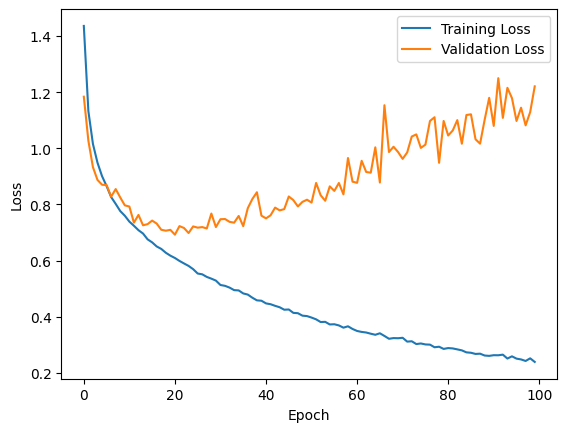

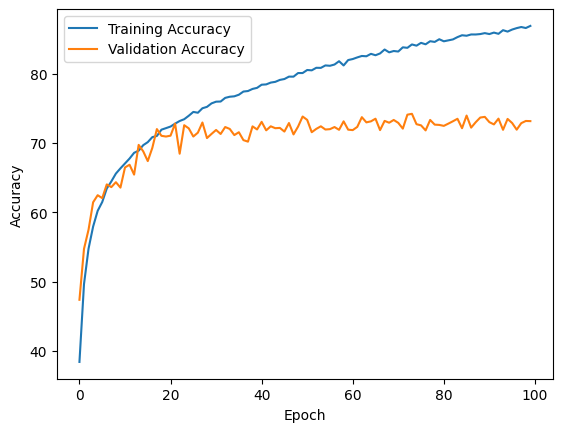

In [15]:
trainset = MFCCDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MFCCDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MFCCDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate best model on test set


In [17]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:02<00:00, 33.39it/s]


Test Accuracy: 0.7297
Test Precision: 0.7354
Test Recall: 0.7297
Test F1-score: 0.7289

              precision    recall  f1-score   support

       Anger       0.66      0.82      0.73       916
       Bored       0.75      0.88      0.81      1098
     Disgust       0.54      0.62      0.57       291
        Fear       0.56      0.56      0.56       308
       Happy       0.79      0.63      0.70      1914
     Neutral       0.70      0.68      0.69      2226
    Question       0.88      0.80      0.84      1139
         Sad       0.74      0.77      0.76       857
    Surprise       0.72      0.78      0.75       728

    accuracy                           0.73      9477
   macro avg       0.70      0.72      0.71      9477
weighted avg       0.74      0.73      0.73      9477



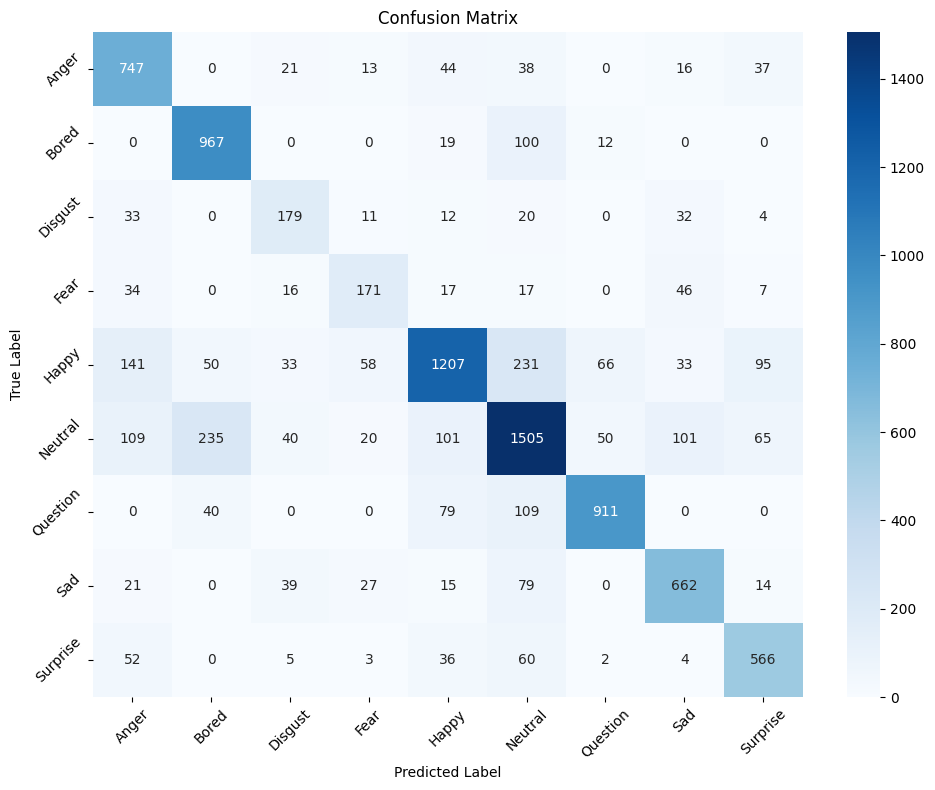

In [19]:
# Load and get predictions from the bets model
best_model_path = f'best_{MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)